In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
# set all pytorch default tensortype to DoubleTensor
torch.set_default_tensor_type('torch.DoubleTensor')

In [2]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_loader = data.DataLoader(
        datasets.ImageFolder('imagefolder',
                             transforms.Compose([
                                 transforms.Resize((150,150)),
                                 #transforms.RandomResizedCrop(224),
                                 #transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 normalize,
                             ])),
        batch_size=4,
        shuffle=True,
        num_workers=5,
pin_memory=True)

test_loader = data.DataLoader(
        datasets.ImageFolder('test_imagefolder',
                             transforms.Compose([
                                 transforms.Resize((150,150)),
                                 #transforms.RandomResizedCrop(224),
                                 #transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 normalize,
                             ])),
        batch_size=4,
        shuffle=True,
        num_workers=5,
pin_memory=True)
classes = ("cat","dog")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  cat   dog   cat   cat


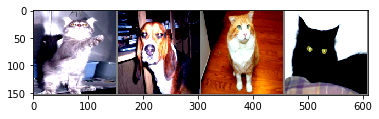

In [3]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 26, 5)
        self.fc1 = nn.Linear(26 * 15 * 15, 40)
        self.fc2 = nn.Linear(40, 40)
        self.fc3 = nn.Linear(40, 20)
        self.fc4 = nn.Linear(20, 20)
        #self.fc5 = nn.Linear(90, 45)
        #self.fc6 = nn.Linear(45,10)
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # refer to this x.size() when changing img size, layers etc
        #print(x.size())
        x = x.view(-1, 26 * 15 * 15)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        #x = F.relu(self.fc4(x))
        #x = F.relu(self.fc5(x))
        x = self.fc4(x)
        return x


net = Net()
# use GPU
#net.cuda()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 26, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=5850, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=20, bias=True)
  (fc4): Linear(in_features=20, out_features=20, bias=True)
)

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001,)

In [6]:
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        # Change the type for Conv
        inputs = inputs.type('torch.DoubleTensor')
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i%100==0:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

RuntimeError: Expected object of type torch.DoubleTensor but found type torch.cuda.DoubleTensor for argument #2 'weight'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    dog   dog   dog   dog


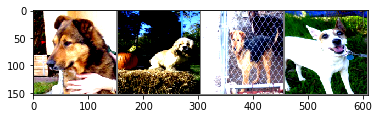

In [31]:
dataiter = iter(test_loader)
testimages, labels = dataiter.next()
testimages = testimages.type('torch.DoubleTensor')
# print images
imshow(torchvision.utils.make_grid(testimages))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [32]:

outputs = net(testimages)

In [33]:
_, predicted = torch.max(outputs, 1)
predicted
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    dog   cat   dog   dog


In [34]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.type('torch.DoubleTensor')
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 55 %


In [ ]:
"""
Utility function for computing output of convolutions
takes a tuple of (h,w) and returns a tuple of (h,w)
"""
def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    print("H calc")
    w = floor( ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    print("w calc")
    return h, w

In [ ]:
conv_output_shape((6,16))